In [100]:
from dotenv import load_dotenv
from helpers.utils import Utils

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle
from ipywidgets import interactive, VBox, Layout, HBox, IntSlider, FloatSlider, IntRangeSlider

from models.peer import Peer
from models.data_model import DataModel

%config InlineBackend.figure_format = 'retina'

In [101]:
use_snapshot = True
min_version = "2.0.7"
budget_dollar = 7500
token_price = 0.05
min_stake_wxhopr = 10e3
thrs_stake_wxhopr = 75e3
transformation_slope = 1
transformation_flattening_factor = 1.4

In [102]:
class StakeModel(DataModel):
    def __init__(self, use_snapshot: bool):
        self.peers = []
        self.topology = []
        self.safe = []
        super().__init__(use_snapshot)
    
    async def get_dynamic_data(self):
        self.safes = await Utils.getSafesData()
        self.topology = await Utils.getTopologyData()
        self.peers = await Utils.getPeers()


    def load_snapshot(self, folder: str):
        self.peers, self.safes, self.topology = Utils.loadSnapshot(folder, "peers", "safes", "topology")
 
    def dump_snapshot(self, folder: str):
        Utils.dumpSnapshot(peers=self.peers, safes=self.safes, topology=self.topology)

    def plot_static(self, ax: plt.Axes, peers: list[Peer], bin: list[int], limits: list[int], token_price: float, watermark: str):
        stakes = [peer.split_stake for peer in peers]
        rewards = [peer.rewards for peer in peers]

        apr = sum(rewards) / sum(stakes) * 12 if sum(stakes) > 0 else 0
    
        texts = [
            f"Stakes: {sum(stakes):_.0f} wxHOPR",
            f"Rewards: {sum(rewards):_.0f} wxHOPR -> Budget: {sum(rewards)*token_price:_.0f} $",
            f"APR (avg.): {apr:.2%}",
            f"Peers: {len(peers)}"
        ]

        # plot
        counts, _, bars = ax.hist(stakes, bins=bin, facecolor="#000050", edgecolor='black', linewidth=1.2, rwidth=.85)
        max_height = max(round(counts.max() / 20 + .5) * 20, 1)
        areas = [
            (((0, 0), limits[0], max_height), "#ff0000"),
            (((limits[0], 0), limits[1]-limits[0], max_height), "#ffffa0")
        ]

        # settings
        ax.bar_label(bars)
        ax.set_xlim(bin[0], bin[-1])
        ax.set_ylim(0, max_height)
        ax.set_xlabel("Stake (wxHOPR)")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        [ax.add_patch(Rectangle(*loc, color=color, alpha=.4, zorder=0)) for loc, color in areas]

        for idx, text in enumerate(texts):
            test_item = ax.text(.95, .95-idx*.1, text, transform=ax.transAxes, ha='right', va='top')
            test_item.set_bbox(dict(facecolor='#b4f0ff', alpha=.5, edgecolor='white'))

        ax.text(0.5, 0.5, watermark, transform=ax.transAxes,
            fontsize=40, color='gray', alpha=0.5,
            ha='center', va='center', rotation=30)

    def plot_static_multi(self, bin_count: int, limits: list[int], slope: float, flattening_factor: float, token_price: float, target_apr: float, random_extra_stake_range: list[int], num_extra_nodes: int, extra_node_apr_factor: float, overlay: str = ""):
        eligibles = Utils.getEligiblesPeers(self.topology, self.peers, self.safes, min_version)
        splited_peers = [[], []]

        ################## ADD EXTRA NODES ################################
        for _ in range(num_extra_nodes):
            eligibles.append(Peer.extra(random_extra_stake_range))

        total_stake = sum(peer.split_stake for peer in eligibles if peer.split_stake > limits[0])
        budget_dollars = target_apr * total_stake / 12 / 100 * token_price

        eligibles = Utils.getRewardProbability(eligibles, token_price, budget_dollars, limits, slope, flattening_factor)

        # probability adjustment
        for peer in eligibles:
            if "extra_address" not in peer.address.address:
                continue
            peer.reward_probability *= extra_node_apr_factor

        total_probability = sum(peer.reward_probability for peer in eligibles)

        # normalize the probability
        for peer in eligibles:
            peer.reward_probability /= total_probability
        ###############################################################################
        
        # split the peers betweenn two groups
        for peer in eligibles:
            splited_peers[peer.split_stake >= limits[1]].append(peer)
        
        # prepare bins for both groups
        bins = [
            Utils.binsFromRange(0, limits[1], bin_count),
            Utils.binsFromRange(limits[1], 1e6, bin_count)
        ]

        _, axes = plt.subplots(1, len(splited_peers)+1, figsize=(8*len(splited_peers), 4.5), sharex=False, sharey=False)
        axes = axes.flatten() if not isinstance(axes, plt.Axes) else [axes]

        for idx, (ax, split, bin) in enumerate(zip(axes[1:], splited_peers, bins)):
            self.plot_static(ax, split, bin, limits, token_price, overlay)

        # Add extra text on the righthand side
        texts = [
            f"Total stake: {total_stake:_.0f} wxHOPR",
            f"Total budget: {budget_dollars:_.0f} $",
            f"Avg. APR: {target_apr:.2f}%",
            f"Total peers: {len(eligibles)}",
        ]
        for idx, text in enumerate(texts):
            text_item = axes[0].text(0.95, .45-idx*.1, text, transform=axes[0].transAxes, ha='right', va='top')
            text_item.set_bbox(dict(facecolor='#b4f0ff', alpha=.5, edgecolor='white'))

        x_range = list(range(int(limits[0]), int(1e6), int(2.5e3)))
        tf_stake = [eligibles[0].economic_model.transformed_stake(stake) for stake in x_range ]

        axes[0].plot(x_range, tf_stake)
        axes[0].set_xlabel("Stake (wxHOPR)")
        axes[0].set_ylabel("Transformed stake (wxHOPR)")

        axes[0].text(0.5, 0.5, overlay, transform=axes[0].transAxes,
            fontsize=40, color='gray', alpha=0.5,
            ha='center', va='center', rotation=30)

        # Finalize the plot
        _ = axes[1].set_ylabel("Number of peers")
        axes[-1].text(1, -0.15, "Budgets are calculated /month", transform=axes[-1].transAxes, ha='right', va='top', style="italic")
        # plt.subplots_adjust(wspace=0.1)

    def plot_interactive(self):
        style = {'description_width': 'initial', 'value_width': 'initial'}

        # histogram controls
        bin_slider = IntSlider(min=5, max=30, step=1, value=15, description="Bins count", style=style)

        # distribution controls
        limits_slider = IntRangeSlider(min=0, max=500e3, step=5e3, description="Eligibility thres.", value=[min_stake_wxhopr, thrs_stake_wxhopr], style=style, layout={"width": "600px"})
        slope_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=transformation_slope, description="Slope", style=style)
        flattening_factor_slider = FloatSlider(min=1, max=3, step=0.1, value=transformation_flattening_factor, description="Flattening factor", style=style)

        # prices
        apr_slider = FloatSlider(min=0.1, max=20.0, step=0.1, value=15, description="Target APR", style=style)
        token_price_slider = FloatSlider(min=0.01, max=0.20, step=0.001, value=token_price, description="Token price ($)",readout_format='.3f', style=style)

        # extra investors sliders
        random_extra_stake_slider = IntRangeSlider(min=0, max=800e3, step=25e3, description="Random stake", value=[250e3, 350e3], style=style, layout={"width": "600px"})
        num_extra_nodes_slider = IntSlider(min=0, max=300, step=1, value=0, description="Extra nodes", style=style)
        extra_node_apr_factor_slider = FloatSlider(min=1, max=10.0, step=0.1, value=1, description="Extra APR boost", style=style)

        # MAIN PLOTS WINDOW
        widgets = interactive(self.plot_static_multi, limits=limits_slider, slope=slope_slider, flattening_factor=flattening_factor_slider, bin_count=bin_slider, token_price=token_price_slider, target_apr=apr_slider, random_extra_stake_range=random_extra_stake_slider, num_extra_nodes=num_extra_nodes_slider,extra_node_apr_factor=extra_node_apr_factor_slider, overlay="Peers\nSimulation")

        distribution_controls = HBox(widgets.children[1:4], layout = Layout(flex_flow='row wrap'))
        prices_controls = HBox(widgets.children[4:6], layout = Layout(flex_flow='row wrap'))
        extra_investor_controls = HBox(widgets.children[6:9], layout = Layout(flex_flow='row wrap'))
        hist_controls = widgets.children[0]

        self.plot_static_multi(limits=[min_stake_wxhopr, thrs_stake_wxhopr], slope=transformation_slope, flattening_factor=transformation_flattening_factor, bin_count=15,token_price=token_price, target_apr=15.0, random_extra_stake_range=[0], num_extra_nodes=0, extra_node_apr_factor=1, overlay="Peers\nStatus quo")

        # self.plot_static_multi(15, [min_stake_wxhopr, thrs_stake_wxhopr], "Safes\nStatus quo")

        display(VBox([distribution_controls, prices_controls, extra_investor_controls, hist_controls]))
        display(widgets.children[-1])

### Get data


In [103]:
model = StakeModel(use_snapshot or not load_dotenv())

model.get_data("2024_02_22")

print(f"Subgraph size: {len(model.safes)}")
print(f"Topology size: {len(model.topology)}" )
print(f"Number of peers: {len(model.peers)}")

Subgraph size: 676
Topology size: 443
Number of peers: 346


Output()

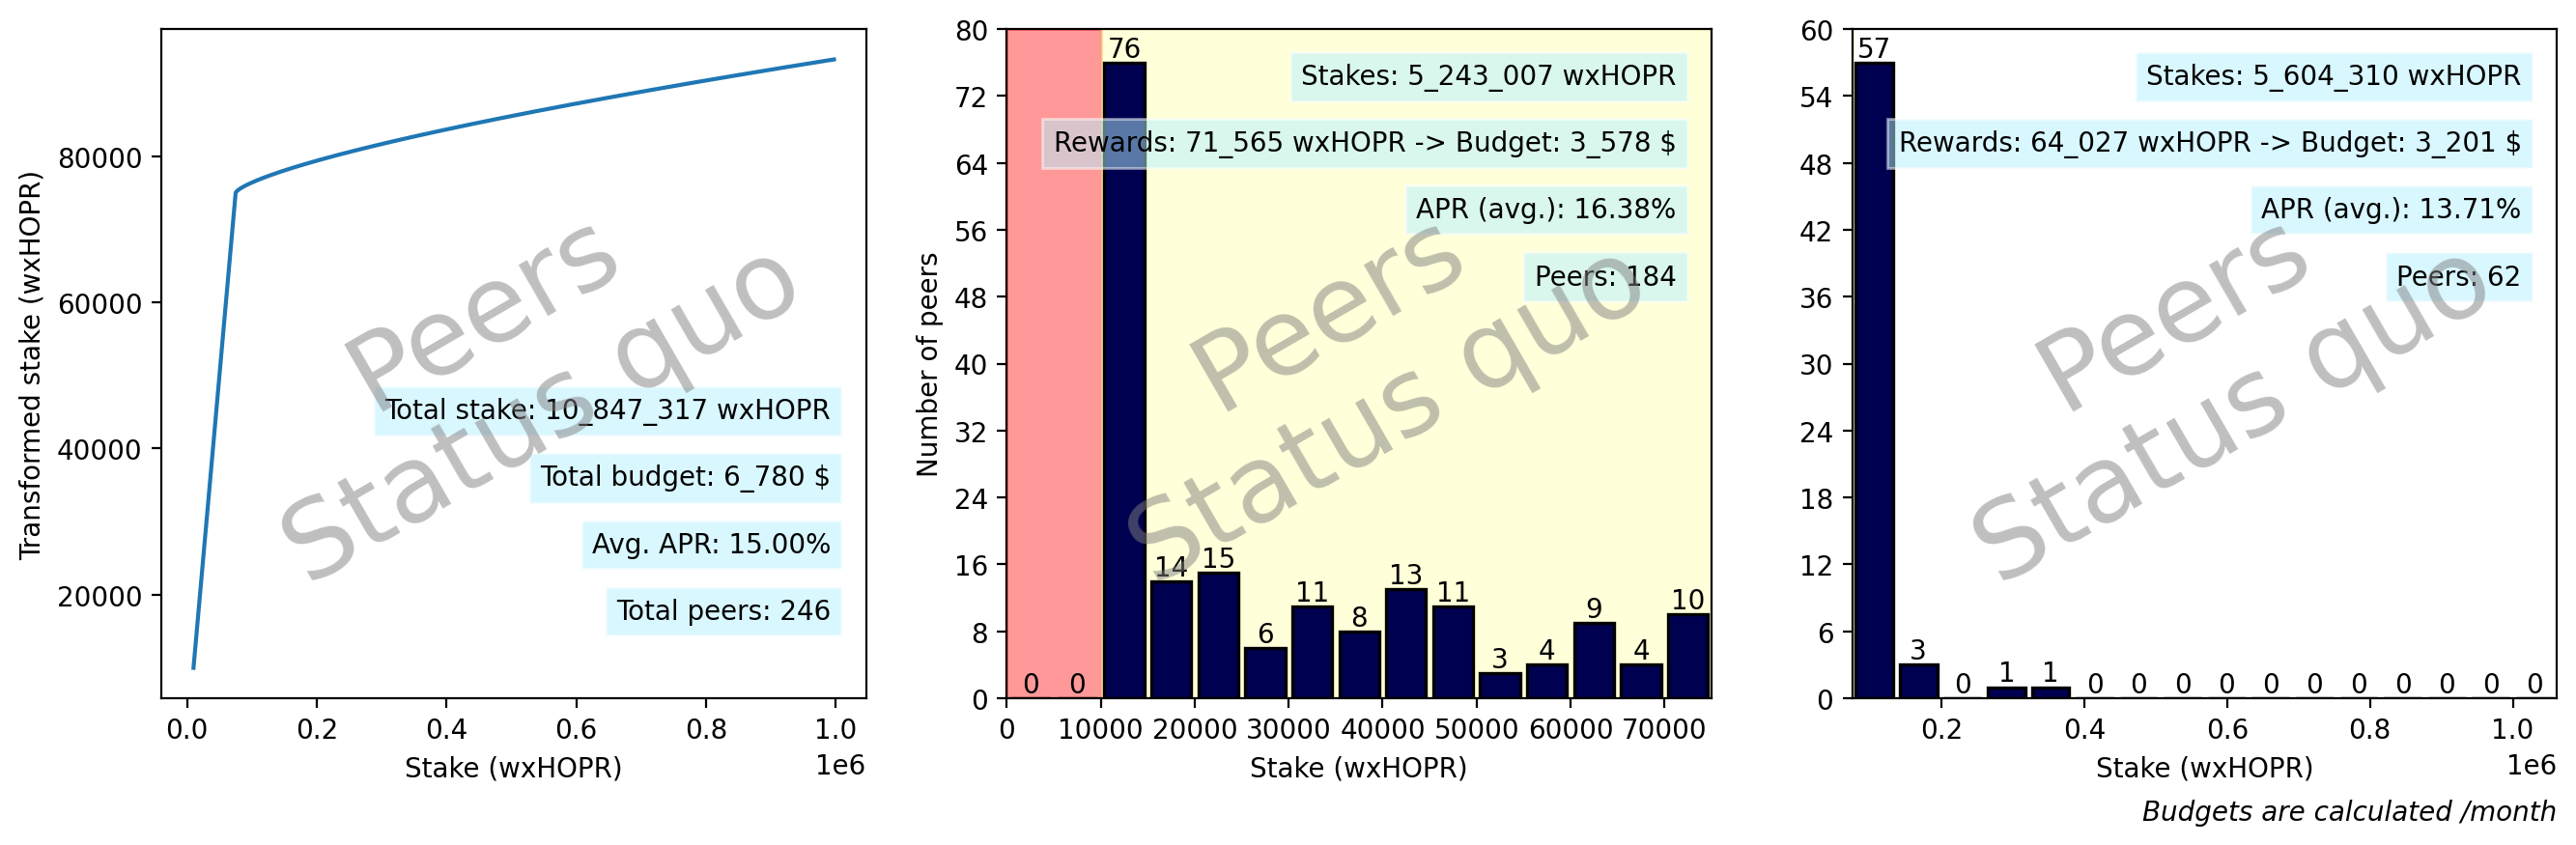

In [104]:
model.plot_interactive()

In [105]:
# def plot_safe_stake_hist(ax: plt.Axes, safes: list[SubgraphEntry], bin: list[int], limits: list[int], watermark: str):
#     # data
#     stakes = [float(safe.wxHoprBalance) for safe in safes]

#     # plot
#     counts, _, bars = ax.hist(stakes, bins=bin, facecolor="#000050", edgecolor='black', linewidth=1.2, rwidth=.85)
#     max_height = max(round(counts.max() / 20 + .5) * 20, 1)
#     areas = [
#         (((0, 0), limits[0], max_height), "#ff0000"),
#         (((limits[0], 0), limits[1]-limits[0], max_height), "#ffffa0")
#     ]

#     # settings
#     ax.bar_label(bars)
#     ax.set_xlim(bin[0], bin[-1])
#     ax.set_ylim(0, max_height)
#     ax.set_xlabel("Stake (wxHOPR)")
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#     [ax.add_patch(Rectangle(*loc, color=color, alpha=.4, zorder=0)) for loc, color in areas]

#     ax.text(0.5, 0.5, watermark, transform=ax.transAxes,
#         fontsize=40, color='gray', alpha=0.5,
#         ha='center', va='center', rotation=30)
    
# def plot_multiple_safe_stake_hist(bin_count: int, limits: list[int], overlay: str = ""):
        
#     separators = [limits[1], 1000e3]

#     splits = [[] for _ in separators]
#     for safe in safes:
#         for idx, sep in enumerate(separators):
#             if float(safe.wxHoprBalance) < sep:
#                 splits[idx].append(safe)
#                 break
        
#     bins = []
#     low = 0
#     for high in separators:
#         bins.append(Utils.binsFromRange(low, high, bin_count))
#         low = high

#     _, axes = plt.subplots(1, len(splits), figsize=(8*len(splits), 4.5), sharex=False, sharey=False)
#     axes = axes.flatten() if not isinstance(axes, plt.Axes) else [axes]

#     for idx, (ax, split, bin) in enumerate(zip(axes, splits, bins)):
#         plot_safe_stake_hist(ax, split, bin, limits, overlay)

#     _ = axes[0].set_ylabel("Number of safes")
#     plt.subplots_adjust(wspace=0.06)


#     style = {'description_width': 'initial', 'value_width': 'initial'}

#     # histogram controls
#     bin_slider = IntSlider(min=5, max=30, step=1, value=15, description="Bins count", style=style)

#     # distribution controls
#     limits_slider = IntRangeSlider(min=0, max=500e3, step=5e3, description="Eligibility thres.", value=[min_stake_wxhopr, thrs_stake_wxhopr], style=style, layout={"width": "600px"})
#     budget_dollars_slider = IntSlider(min=0, max=20000, step=500, value=budget_dollar, description="Budget ($)", style=style)
#     apr_slider = FloatSlider(min=0.1, max=20.0, step=0.1, value=15, description="Target APR", style=style)
#     token_price_slider = FloatSlider(min=0.01, max=0.20, step=0.001, value=token_price, description="Token price ($)",readout_format='.3f', style=style)

#     # extra investors sliders
#     random_extra_stake_slider = IntRangeSlider(min=0, max=800e3, step=25e3, description="Random stake", value=[250e3, 350e3], style=style, layout={"width": "600px"})
#     num_extra_nodes_slider = IntSlider(min=0, max=300, step=1, value=0, description="Extra nodes", style=style)
#     extra_node_apr_factor_slider = FloatSlider(min=1, max=10.0, step=0.1, value=1, description="Extra APR boost", style=style)

#     widgets = interactive(plot_multiple_split_stake_hist, limits=limits_slider, bin_count=bin_slider, token_price=token_price_slider, target_apr=apr_slider, random_extra_stake_range=random_extra_stake_slider, num_extra_nodes=num_extra_nodes_slider,extra_node_apr_factor=extra_node_apr_factor_slider, overlay="Peers\nSimulation")

#     reward_controls = HBox(widgets.children[1:4], layout = Layout(flex_flow='row wrap'))
#     extra_investor_controls = HBox(widgets.children[4:7], layout = Layout(flex_flow='row wrap'))
#     hist_controls = widgets.children[0]

#     plot_multiple_split_stake_hist(limits=[min_stake_wxhopr, thrs_stake_wxhopr], bin_count=15,token_price=token_price, target_apr=15.0, random_extra_stake_range=[0], num_extra_nodes=0, extra_node_apr_factor=1, overlay="Peers\nStatus quo")

#     plot_multiple_safe_stake_hist(15, [min_stake_wxhopr, thrs_stake_wxhopr], "Safes\nStatus quo")

#     display(VBox([reward_controls, extra_investor_controls, hist_controls]))
#     display(widgets.children[-1])